# Reward term functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
max_v = 1.5
dt = 0.2

# action penalty
def r_aug(action):
    # FIXME this is not fine because one action is [0,1] and one is [-0.5, 0.5]
    return 1 - (np.abs(action).mean() * 2)

action = np.random.rand(5000, 2) * 2 - 1
x_a = np.abs(action).sum(axis=1)
y_a = [r_aug(a) for a in action]
# sort by x_a
x_a, y_a = zip(*sorted(zip(x_a, y_a)))

# goal distance
def r_goal_dist(goal_dist_diff):
    return goal_dist_diff / (max_v * dt)
    
goal_dist_diff = (np.random.rand(1000) * 2 - 1) * max_v * dt
x_d = goal_dist_diff
y_d = [r_goal_dist(d) for d in goal_dist_diff]

x_d, y_d = zip(*sorted(zip(x_d, y_d)))

# speed
tau = 0.942
v_ref = 0.8 * max_v

def expectile(x, tau):
    y = np.zeros_like(x)
    pos_x_map = x > 0
    y[pos_x_map] = tau * x[pos_x_map]**2
    y[~pos_x_map] = (1-tau) * x[~pos_x_map]**2
    return y

max_value = max(expectile(np.array(-v_ref), tau), expectile(np.array(max_v - v_ref), tau))
# print(max_value)

def r_speed(vel):
    v_err = vel - v_ref
    return 1 - ((expectile(v_err, tau) * 2) / max_value)
    
vs = np.random.rand(1000) * max_v
x_s = vs
y_s = [r_speed(v) for v in vs]
x_s, y_s = zip(*sorted(zip(x_s, y_s)))

# angular velocity


max_omega = 0.5
tau_omega = 0.5
max_value = expectile(np.array(max_omega), tau_omega)
def r_angular_speed(omega):
    return 1 - ((expectile(np.abs(omega), tau_omega) * 2) / max_value)

omegas = np.random.rand(1000) - 0.5
x_av = omegas
y_av = r_angular_speed(omegas)
x_av, y_av = zip(*sorted(zip(x_av, y_av)))

# cross track error
max_error = 5.

def r_cross_track(ct_err):
    reward = 1 - (2 * np.abs(ct_err) / max_error)
    reward = np.clip(reward, -1, 1)
    return reward
    
ct_errs = (np.random.rand(1000) * 2 - 1) * 12
x_ct = ct_errs
y_ct = [r_cross_track(e) for e in ct_errs]
x_ct, y_ct = zip(*sorted(zip(x_ct, y_ct)))

# obstacle distance
max_obstacle_dist = 1.

def r_obstacle_dist(obstacle_dist):
    rwd = -1 + 2 * (obstacle_dist / max_obstacle_dist)
    return min(1, max(-1, rwd))

obstacle_dist = np.random.rand(1000) * 2
x_o = obstacle_dist
y_o = [r_obstacle_dist(o) for o in obstacle_dist]
x_o, y_o = zip(*sorted(zip(x_o, y_o)))

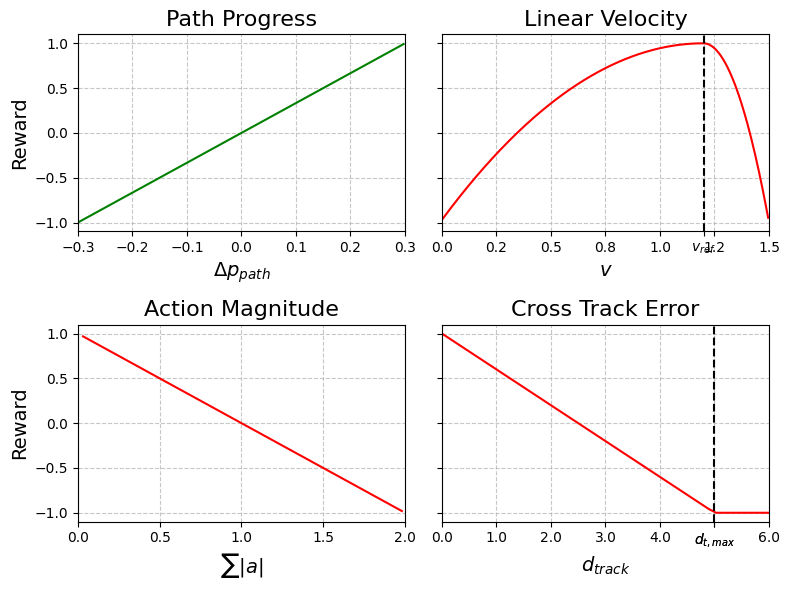

In [423]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharey=True)

axs[0,0].plot(x_d, y_d, c='g')
axs[0,0].set_title('Path Progress', fontsize=16)
axs[0,0].set_xlabel('$\Delta p_{path}$', fontsize=14)
axs[0,0].set_ylabel('Reward', fontsize=14)
axs[0,0].set_xlim(-.3, .3)

axs[1,0].plot(x_a, y_a, c='r')
axs[1,0].set_title('Action Magnitude', fontsize=16)
axs[1,0].set_xlabel('$\sum |a|$', fontsize=14)
axs[1,0].set_ylabel('Reward', fontsize=14)
axs[1,0].set_xlim(0., 2.)

axs[0,1].plot(x_s, y_s, c='r')
axs[0,1].plot([v_ref, v_ref], [-1.1, 1.1], '--', color="black")
axs[0,1].set_title('Linear Velocity', fontsize=16)
axs[0,1].set_xlabel('$v$', fontsize=14)
axs[0,1].set_xlim(0., 1.5)
axs[0,1].set_xticks(list(axs[0,1].get_xticks()) + [1.2])
axs[0,1].set_xticklabels([f'{tick:.1f}' if tick != 1.2 else '$v_{ref}$' for tick in axs[0,1].get_xticks()])

axs[1,1].plot(x_ct, y_ct, c='r')
axs[1,1].plot([5., 5.], [-1.1, 1.1], '--', color="black")
axs[1,1].set_title('Cross Track Error', fontsize=16)
axs[1,1].set_xlabel('$d_{track}$', fontsize=14)
axs[1,1].set_xlim(0., 6.)
axs[1,1].set_xticks(list(axs[1,1].get_xticks()) + [5.0])
axs[1,1].set_xticklabels([f'{tick:.1f}' if tick != 5.0 else '$d_{t,max}$' for tick in axs[1,1].get_xticks()])
# axs[1,1].tick_params(axis='x', rotation=45)


for ax in axs:
    for a in ax:
        a.grid(True, linestyle='--', alpha=0.7)
        a.set_ylim(-1.1, 1.1)

plt.tight_layout()
plt.savefig('../figures/dense_reward_functions.png', dpi=400)
plt.show()

In [13]:
100/(6*500)

0.03333333333333333

In [14]:
1/30

0.03333333333333333

In [11]:
from collections import defaultdict

high_speed = 1.5
ideal_speed = v_ref
low_speed = 0.0

# low_angular_v = 0.0
# high_angular_v = 0.5

# high_obstacle_dist = 2.0
# low_obstacle_dist = 0.01

high_ct_err = 10.
low_ct_err = .5

high_action_mag = np.array([1.5, -.5])
low_action_mag = np.array([0.1, .1])

max_timesteps = 400

reach_goal_reward = 100
stop_reward = 0
crash_reward = -100

# scenarios = ['reach_goal', 'stop', 'p_1_crash', 'crash']
# scene_timesteps = [[100, 250], [300], [50, 100, 250], [30, 100, 250]]
scenarios = ['reach_goal', 'stop', 'crash']
scene_timesteps = [[100, 250], [max_timesteps], [30, 150, 250]]

w = 0.1
b = 0.

w1 = 0.1
b1 = 0.

results = defaultdict(list)

for i, scene in enumerate(scenarios):
    timesteps = scene_timesteps[i]
    for tsteps in timesteps:
        r_sparse = 0
        if scene == 'reach_goal':
            r_sparse += reach_goal_reward
        elif scene == 'stop':
            r_sparse += stop_reward
        elif scene == 'crash':
            r_sparse += crash_reward
        elif scene == 'p_1_crash':
            r_sparse += crash_reward * 0.01 + reach_goal_reward * 0.99

        r_dense = 0
        r_dense += w * (r_speed(np.array(ideal_speed)) - b)
        r_dense += w1 * (r_cross_track(low_ct_err) - b1)
        r_dense += w1 * (r_aug(low_action_mag) - b1)

        ideal_reward = r_sparse + r_dense * tsteps
        print(f'{scene} with {tsteps} timesteps: {ideal_reward}')

        r_dense = 0
        r_dense += w * (r_speed(np.array(high_speed)) - b)
        r_dense += w1 * (r_cross_track(low_ct_err) - b1)
        r_dense += w1 * (r_aug(low_action_mag) - b1)

        speed_bad_1_reward = r_sparse + r_dense * (tsteps - (25/tsteps))

        r_dense = 0
        r_dense += w * (r_speed(np.array(low_speed)) - b)
        r_dense += w1 * (r_cross_track(low_ct_err) - b1)
        r_dense += w1 * (r_aug(low_action_mag) - b1)

        speed_bad_2_reward = r_sparse + r_dense * (tsteps + (25/tsteps))

        r_dense = 0
        r_dense += w * (r_speed(np.array(ideal_speed)) - b)
        r_dense += w1 * (r_cross_track(high_ct_err) - b1)
        r_dense += w1 * (r_aug(low_action_mag) - b1)

        x_bad_reward = r_sparse + r_dense * tsteps

        r_dense = 0
        r_dense += w * (r_speed(np.array(ideal_speed)) - b)
        r_dense += w1 * (r_cross_track(low_ct_err) - b1)
        r_dense += w1 * (r_aug(high_action_mag) - b1)

        aug_bad_reward = r_sparse + r_dense * tsteps

        r_dense = 0
        r_dense += w * (r_speed(np.array(low_speed)) - b)
        r_dense += w1 * (r_cross_track(high_ct_err) - b1)
        r_dense += w1 * (r_aug(high_action_mag) - b1)

        worst_case = r_sparse + r_dense * tsteps


        rewards = [ideal_reward, speed_bad_1_reward, speed_bad_2_reward, x_bad_reward, aug_bad_reward, worst_case]

        results[scene].append(rewards)

for key in results:
    results[key] = np.array(results[key])

reach_goal with 100 timesteps: 127.0
reach_goal with 250 timesteps: 167.5
stop with 400 timesteps: 108.0
crash with 30 timesteps: -91.9
crash with 150 timesteps: -59.5
crash with 250 timesteps: -32.5


In [12]:
# TODO it gets positive path progress reward when driving backwards

In [15]:
results['reach_goal'].max(), results['reach_goal'].min(), results['stop'].max(), results['stop'].min(), results['crash'].max()

(167.5, 41.591999999999956, 108.0, -93.45280000000007, -32.5)

In [14]:
# category_check = results['reach_goal'].min() > results['stop'].max() > results['p_1_crash'].max() > results['crash'].max()
category_check = results['reach_goal'].min() > results['stop'].max() and results['stop'].min() > results['crash'].max()
if category_check:
    print('Category check passed!')
else:
    print('Category check failed!')

inner_check = True
for key, value in results.items():
    inner_cat_check = (value[:,0] > value[:,1:].max(axis=1)).all()
    if not inner_cat_check:
        print(f'Inner check failed for {key}')
        inner_check = False

if inner_check:
    print('Inner check passed!')

if inner_check and category_check:
    print('All checks passed!')
else:
    failed_checks = int(not inner_check) + int(not category_check)
    print(f'Number of checks that failed: {failed_checks}/2')

Category check failed!
Inner check passed!
Number of checks that failed: 1/2


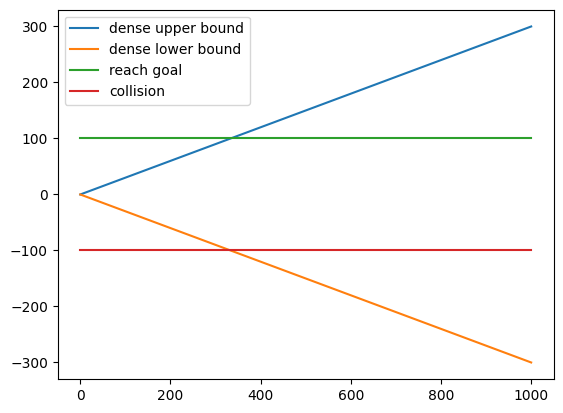

In [36]:
# worst case scenario

w = 0.1
max_timesteps = 1000

reach_goal = 100
collision = -100

x = np.linspace(0, max_timesteps)
lower_bound = -3 * w * x
upper_bound = 3 * w * x

# in case of a crash, dense terms should not be relevant
# in case of stop, dense terms should ?
# in case of reaching the goal, dense terms matter

# i.e. dense terms only matter when reaching the goal

plt.plot(x, upper_bound, label="dense upper bound")
plt.plot(x, lower_bound, label="dense lower bound")
plt.plot([0, max_timesteps], [reach_goal, reach_goal], label="reach goal")
plt.plot([0, max_timesteps], [collision, collision], label="collision")
plt.legend()
plt.show()

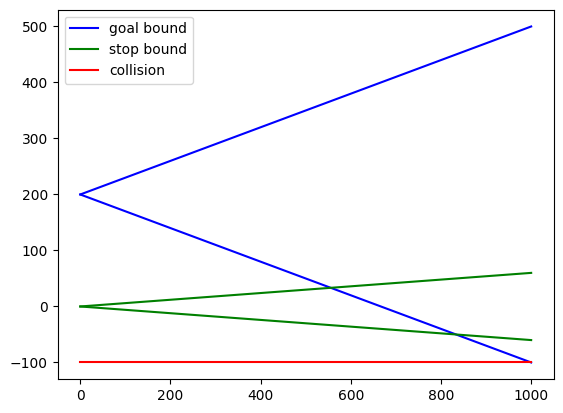

In [492]:
# worst case scenario

w = 0.1
max_timesteps = 1000

reach_goal = 200
collision = -100
stop = 0

x = np.linspace(0, max_timesteps)

goal_lower_bound = reach_goal - 3 * w * x
goal_upper_bound = reach_goal + 3 * w * x

stop_lower_bound = - 3 * .2 * w * x
stop_upper_bound = + 3 * .2 * w * x

# in case of a crash, dense terms should not be relevant
# in case of stop, dense terms should ?
# in case of reaching the goal, dense terms matter

# i.e. dense terms only matter when reaching the goal

plt.plot(x, goal_lower_bound, c="b")
plt.plot(x, goal_upper_bound, c="b", label="goal bound")
plt.plot(x, stop_lower_bound, c="g")
plt.plot(x, stop_upper_bound, c="g", label="stop bound")
# plt.plot([0, max_timesteps], [stop, stop], label="stop")
plt.plot([0, max_timesteps], [collision, collision], c="r", label="collision")
plt.legend()
plt.show()

In [36]:
wc = 0.1
100 + 3 * wc * 200, 3 * wc * 500

(160.0, 150.00000000000003)

In [39]:
-100 - 3 * 50* wc, -3 * wc * 300

(-115.0, -90.00000000000001)

# Reward term sweep results

In [395]:
import seaborn as sns
cmp = sns.color_palette("colorblind")

baseline_color = cmp[0]
cr_base_color = cmp[1]
ours_color = cmp[2]
other_colors = cmp[3:]

cmp

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

### Exp 0: Reward terms

In [157]:
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sweep_id = "pn2zlm7d"
sweep_id = "1ljnrdye"

api = wandb.Api()
sweep = api.sweep(f"kilian/DRL-Traj-Planner/{sweep_id}")

# Fetch the history of all runs in the sweep
history_list = []
for run in sweep.runs:
    run_history = run.history(keys=["train/episode_success", "train/episode_length", "train/true_reward"],
                              pandas=True,
                              samples=200_000)
    params = run.config
    run_history["base_rewards"] = params["sac"]["curriculum"]["base_reward_keys"]
    run_history["seed"] = params["seed"]

    history_list.append(run_history)

history = pd.concat(history_list)
history["base_rewards"].value_counts()

base_rewards
gdcsax    800
gdc       800
gda       800
gdx       800
gds       800
gd        800
Name: count, dtype: int64

In [158]:
history["base_rewards"] = history["base_rewards"].replace("gdcsax", "full")
history["base_rewards"] = history["base_rewards"].apply(lambda x: f"r_{{ {x} }}")
history["_step"] /= 1000

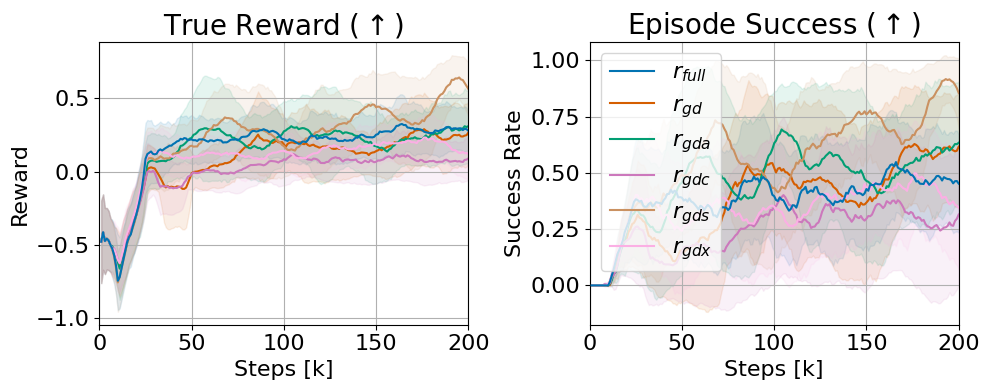

In [417]:
grouped = history.groupby("base_rewards")

# Initialize the plots
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

# Plot each metric
metrics = ["train/true_reward", "train/episode_success"]
titles = ["True Reward ($\\uparrow$)", "Episode Success ($\\uparrow$)"]
y_labels = ["Reward", "Success Rate"]

colors = [baseline_color, other_colors[0], ours_color, other_colors[1], other_colors[2], other_colors[3]]

for i, metric in enumerate(metrics):
    for g_idx, (name, group) in enumerate(grouped):
        mean_values = group.groupby("_step")[metric].mean()
        std_values = group.groupby("_step")[metric].std()
        timesteps = mean_values.index

        # Apply rolling window after the initial values
        mean_values_rolling = mean_values.rolling(window=15, min_periods=1).mean()
        std_values_rolling = std_values.rolling(window=15, min_periods=1).mean()

        c = colors[g_idx]
        z_order = 4 if g_idx == 0 else None
        # z_order = 3 if g_idx == 2 else None
        axs[i].plot(timesteps, mean_values_rolling, label=f"${name}$", color=c, zorder=z_order)
        axs[i].fill_between(timesteps, mean_values_rolling - std_values_rolling, mean_values_rolling + std_values_rolling, alpha=0.1, color=c)

    axs[i].set_title(titles[i], fontsize=20)
    axs[i].set_xlabel("Steps [k]", fontsize=16)
    axs[i].set_ylabel(y_labels[i], fontsize=16)
    axs[i].grid(True)
    axs[i].set_xlim(0, 200)
    axs[i].tick_params(axis='both', which='major', labelsize=16)

axs[-1].legend(loc='upper left', fontsize=16)


plt.tight_layout()
plt.savefig("../figures/exp0_reward_subsets.png", dpi=400)
plt.show()


### Exp 1: Basic curriculum

In [306]:
exp1_sweep_id = "u2zb0c1u"

api = wandb.Api()
exp1_sweep = api.sweep(f"kilian/DRL-Traj-Planner/{exp1_sweep_id}")

# Fetch the history of all runs in the sweep
history_list_exp1 = []
for run in exp1_sweep.runs:
    run_history = run.history(keys=["train/episode_success", "train/episode_length", "train/true_reward", "train/episode_reward", "train/episode_collided", "train/entropy", "train/loss_alpha"],
                              pandas=True,
                              samples=1_000_000)
    params = run.config
    run_history["reward_mode"] = params["reward_mode"]
    run_history["seed"] = params["seed"]
    run_history["path"] = params["path"]

    history_list_exp1.append(run_history)

exp1_history = pd.concat(history_list_exp1)

exp1_history["_step"] /= 1000
exp1_history["reward_mode"] = exp1_history["reward_mode"].replace("curriculum_step", "SAC w/ Basic RC")
exp1_history["reward_mode"] = exp1_history["reward_mode"].replace("sum", "SAC")
exp1_history["reward_mode"].value_counts()

reward_mode
SAC                9960
SAC w/ Basic RC    9960
Name: count, dtype: int64

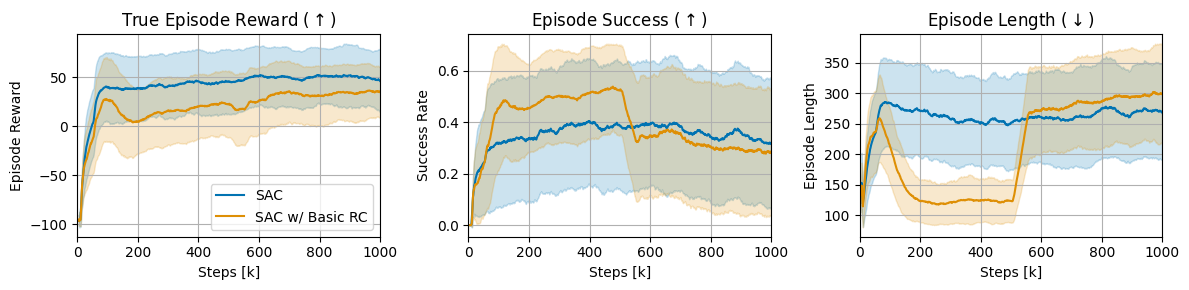

In [410]:
grouped = exp1_history.groupby("reward_mode")

# Initialize the plots
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

# Plot each metric
metrics = ["train/episode_reward", "train/episode_success", "train/episode_length"]
titles = ["True Episode Reward ($\\uparrow$)", "Episode Success ($\\uparrow$)", "Episode Length ($\downarrow$)"]
y_labels = ["Episode Reward", "Success Rate", "Episode Length"]

colors = [baseline_color, cr_base_color]

for i, metric in enumerate(metrics):
    for g_idx, (name, group) in enumerate(grouped):
        mean_values = group.groupby("_step")[metric].mean()
        std_values = group.groupby("_step")[metric].std()
        timesteps = mean_values.index

        # Apply rolling window after the initial values
        mean_values_rolling = mean_values.rolling(window=50, min_periods=1).mean()
        std_values_rolling = std_values.rolling(window=50, min_periods=1).mean()

        c = colors[g_idx]
        axs[i].plot(timesteps, mean_values_rolling, label=f"{name}", color=c)
        axs[i].fill_between(timesteps, mean_values_rolling - std_values_rolling, mean_values_rolling + std_values_rolling, alpha=0.2, color=c)

    axs[i].set_title(titles[i])
    axs[i].set_xlabel("Steps [k]")
    axs[i].set_ylabel(y_labels[i])
    axs[i].grid(True)
    axs[i].set_xlim(0, 1000)

axs[0].legend()
plt.tight_layout()
plt.savefig("../figures/exp1_reward_mode.png", dpi=400)
plt.show()

### Exp 1: Num updates

In [201]:
exp2_sweep_id = "7i8hc1tw"

api = wandb.Api()
exp2_sweep = api.sweep(f"kilian/DRL-Traj-Planner/{exp2_sweep_id}")

# Fetch the history of all runs in the sweep
history_list_exp2 = []
for run in exp2_sweep.runs:
    run_history = run.history(keys=["train/episode_success", "train/episode_length", "train/true_reward", "train/episode_reward"],
                              pandas=True,
                              samples=1_000_000)
    params = run.config
    run_history["num_updates"] = "updates_" + str(params["sac"]["curriculum"]["num_updates_after_update"])
    run_history["seed"] = params["seed"]

    history_list_exp2.append(run_history)

exp2_history = pd.concat(history_list_exp2)

exp2_history["_step"] /= 1000
exp2_history["num_updates"] = exp2_history["num_updates"].apply(lambda x: f"$n_{{cr}}$={x.split('_')[-1]}")

In [202]:
exp2_history["num_updates"].value_counts()

num_updates
$n_{cr}$=25000    10000
$n_{cr}$=50000    10000
$n_{cr}$=1000     10000
Name: count, dtype: int64

In [321]:
no_transfer_df = exp1_history[exp1_history["reward_mode"]=="SAC w/ Basic RC"].copy()
no_transfer_df["num_updates"] = "No transfer"

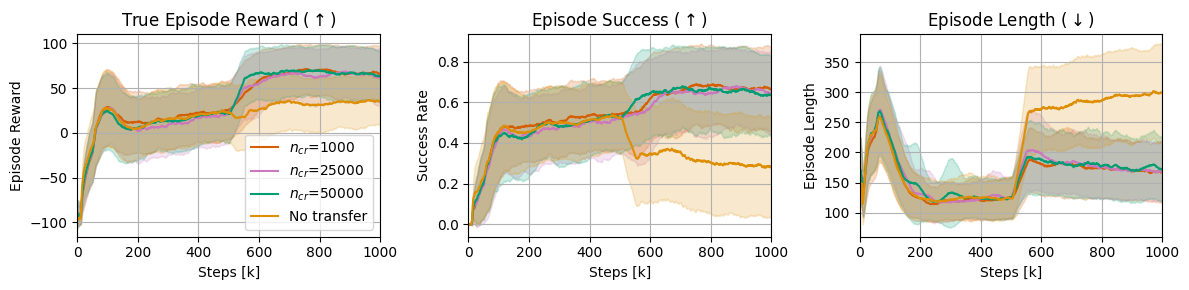

In [412]:
exp_combined_hist = pd.concat([no_transfer_df, exp2_history])

grouped = exp_combined_hist.groupby("num_updates")

# Initialize the plots
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

# Plot each metric
metrics = ["train/episode_reward", "train/episode_success", "train/episode_length"]
titles = ["True Episode Reward ($\\uparrow$)", "Episode Success ($\\uparrow$)", "Episode Length ($\downarrow$)"]
y_labels = ["Episode Reward", "Success Rate", "Episode Length"]

colors = [other_colors[0], other_colors[1], ours_color, cr_base_color]

for i, metric in enumerate(metrics):
    for g_idx, (name, group) in enumerate(grouped):
        mean_values = group.groupby("_step")[metric].mean()
        std_values = group.groupby("_step")[metric].std()
        timesteps = mean_values.index

        # Apply rolling window after the initial values
        mean_values_rolling = mean_values.rolling(window=50, min_periods=1).mean()
        std_values_rolling = std_values.rolling(window=50, min_periods=1).mean()

        c = colors[g_idx]
        axs[i].plot(timesteps, mean_values_rolling, label=f"{name}", color=c)
        axs[i].fill_between(timesteps, mean_values_rolling - std_values_rolling, mean_values_rolling + std_values_rolling, alpha=0.2, color=c)

    axs[i].set_title(titles[i])
    axs[i].set_xlabel("Steps [k]")
    axs[i].set_ylabel(y_labels[i])
    axs[i].grid(True)
    axs[i].set_xlim(0, 1000)
    axs[i].tick_params(axis='both', which='major')

axs[0].legend()
plt.tight_layout()
plt.savefig("../figures/exp2_num_updates.png", dpi=400)
plt.show()

### Exp 3: Curriculum start

In [290]:
exp3_sweep_id = "75t8bv3r"

api = wandb.Api()
exp3_sweep = api.sweep(f"kilian/DRL-Traj-Planner/{exp3_sweep_id}")

# Fetch the history of all runs in the sweep
history_list_exp3 = []
for run in exp3_sweep.runs:
    run_history = run.history(keys=["train/episode_success", "train/episode_length", "train/true_reward", "train/episode_reward", "train/episode_collided", "train/entropy", "train/loss_alpha", "train/alpha", "train/loss_qvalue"],
                              pandas=True,
                              samples=1_000_000)
    params = run.config
    run_history["t_cr"] = "$T_{cr}$=" + str(params["sac"]["curriculum"]["steps_stage_1"])
    run_history["seed"] = params["seed"]
    run_history["path"] = params["path"]

    history_list_exp3.append(run_history)

exp3_history = pd.concat(history_list_exp3)

exp3_history["_step"] /= 1000
exp3_history["t_cr"].value_counts()

t_cr
$T_{cr}$=350000    9960
$T_{cr}$=500000    9960
$T_{cr}$=200000    9960
Name: count, dtype: int64

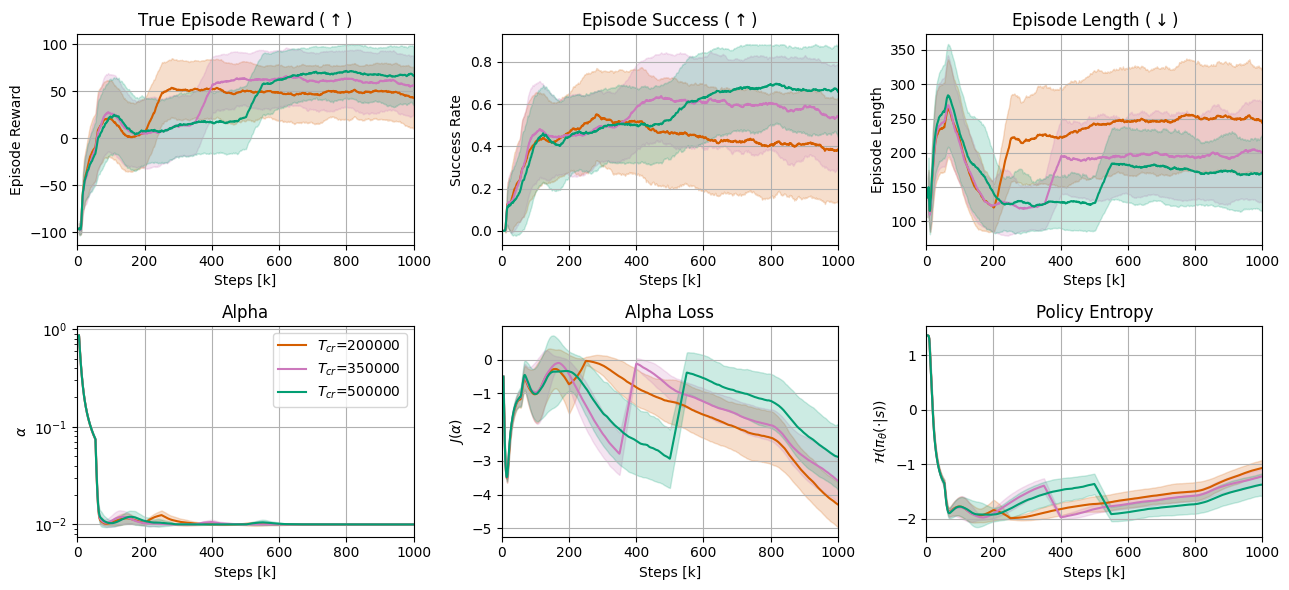

In [413]:
grouped = exp3_history.groupby("t_cr")

# Initialize the plots
fig, axs = plt.subplots(2, 3, figsize=(13, 6), squeeze=False)

# Plot each metric
metrics = ["train/episode_reward", "train/episode_success", "train/episode_length", "train/alpha", "train/loss_alpha", "train/entropy"]
titles = ["True Episode Reward ($\\uparrow$)", "Episode Success ($\\uparrow$)", "Episode Length ($\downarrow$)", "Alpha", "Alpha Loss", "Policy Entropy"]
y_labels = ["Episode Reward", "Success Rate", "Episode Length", "$\\alpha$", "$J(\\alpha)$", "$\mathcal{H}(\\pi_\\theta(\\cdot|s))$"]


colors = [other_colors[0], other_colors[1], ours_color]

for i, metric in enumerate(metrics):
    ix = i // 3
    iy = i % 3
    for g_idx, (name, group) in enumerate(grouped):
        mean_values = group.groupby("_step")[metric].mean()
        std_values = group.groupby("_step")[metric].std()
        timesteps = mean_values.index

        # Apply rolling window after the initial values
        mean_values_rolling = mean_values.rolling(window=50, min_periods=1).mean()
        std_values_rolling = std_values.rolling(window=50, min_periods=1).mean()

        c = colors[g_idx]
        axs[ix,iy].plot(timesteps, mean_values_rolling, label=f"{name}", color=c)
        axs[ix,iy].fill_between(timesteps, mean_values_rolling - std_values_rolling, mean_values_rolling + std_values_rolling, alpha=0.2, color=c)

    axs[ix,iy].set_title(titles[i])
    axs[ix,iy].set_xlabel("Steps [k]")
    axs[ix,iy].set_ylabel(y_labels[i])
    axs[ix,iy].grid(True)
    axs[ix,iy].set_xlim(0, 1000)
    axs[ix,iy].tick_params(axis='both', which='major')

axs[1,0].set_yscale('log')

axs[1,0].legend()
plt.tight_layout()
plt.savefig("../figures/exp3_cr_start.png", dpi=400)
plt.show()

In [298]:
best_cr_df = exp3_history[exp3_history["t_cr"] == "$T_{cr}$=500000"]

In [299]:
best_cr_df["reward_mode"] = "RC-SAC (Ours)"

/var/folders/ty/jjjjks0915bbwk3gy56_q4840000gn/T/ipykernel_81968/3365634755.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_cr_df["reward_mode"] = "RC-SAC (Ours)"


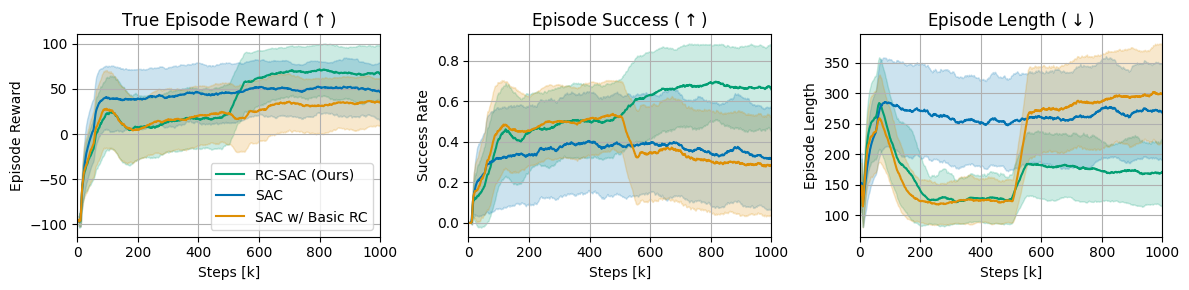

In [414]:
comparison_df = pd.concat([exp1_history, best_cr_df])
grouped = comparison_df.groupby("reward_mode")

# Initialize the plots
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

# Plot each metric
metrics = ["train/episode_reward", "train/episode_success", "train/episode_length"]#, "train/entropy", "train/loss_alpha"]
titles = ["True Episode Reward ($\\uparrow$)", "Episode Success ($\\uparrow$)", "Episode Length ($\downarrow$)"]#, "Entropy", "Alpha Loss"]
y_labels = ["Episode Reward", "Success Rate", "Episode Length"]#, "Entropy", "Alpha Loss"]

colors = [ours_color, baseline_color, cr_base_color]

for i, metric in enumerate(metrics):
    for g_idx, (name, group) in enumerate(grouped):
        mean_values = group.groupby("_step")[metric].mean()
        std_values = group.groupby("_step")[metric].std()
        timesteps = mean_values.index

        # Apply rolling window after the initial values
        mean_values_rolling = mean_values.rolling(window=50, min_periods=1).mean()
        std_values_rolling = std_values.rolling(window=50, min_periods=1).mean()

        c = colors[g_idx]
        axs[i].plot(timesteps, mean_values_rolling, label=f"{name}", color=c)
        axs[i].fill_between(timesteps, mean_values_rolling - std_values_rolling, mean_values_rolling + std_values_rolling, alpha=0.2, color=c)

    axs[i].set_title(titles[i])
    axs[i].set_xlabel("Steps [k]")
    axs[i].set_ylabel(y_labels[i])
    axs[i].grid(True)
    axs[i].set_xlim(0, 1000)

axs[0].legend()
plt.tight_layout()
plt.savefig("../figures/method_comparison.png", dpi=400)
plt.show()

In [343]:
filtered_df = comparison_df[comparison_df["reward_mode"] != "SAC w/ Basic RC"]

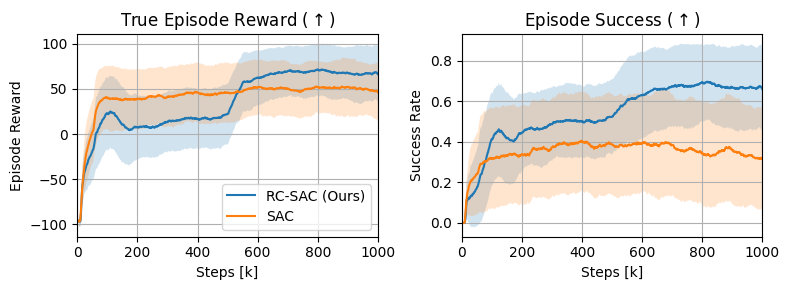

In [344]:
grouped = filtered_df.groupby("reward_mode")

# Initialize the plots
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

# Plot each metric
metrics = ["train/episode_reward", "train/episode_success"]#, "train/entropy", "train/loss_alpha"]
titles = ["True Episode Reward ($\\uparrow$)", "Episode Success ($\\uparrow$)"]#, "Entropy", "Alpha Loss"]
y_labels = ["Episode Reward", "Success Rate"]#, "Entropy", "Alpha Loss"]

for i, metric in enumerate(metrics):
    for name, group in grouped:
        mean_values = group.groupby("_step")[metric].mean()
        std_values = group.groupby("_step")[metric].std()
        timesteps = mean_values.index

        # Apply rolling window after the initial values
        mean_values_rolling = mean_values.rolling(window=50, min_periods=1).mean()
        std_values_rolling = std_values.rolling(window=50, min_periods=1).mean()

        axs[i].plot(timesteps, mean_values_rolling, label=f"{name}")
        axs[i].fill_between(timesteps, mean_values_rolling - std_values_rolling, mean_values_rolling + std_values_rolling, alpha=0.2)

    axs[i].set_title(titles[i])
    axs[i].set_xlabel("Steps [k]")
    axs[i].set_ylabel(y_labels[i])
    axs[i].grid(True)
    axs[i].set_xlim(0, 1000)

axs[0].legend()
plt.tight_layout()
# plt.savefig("../figures/method_comparison.png", dpi=400)
plt.show()

In [247]:
grouped = comparison_df.groupby("reward_mode")
metrics = ["train/episode_reward", "train/episode_success", "train/episode_length"]
results = []

for i, metric in enumerate(metrics):
    for name, group in grouped:
        mean_values = group.groupby("_step")[metric].mean()
        std_values = group.groupby("_step")[metric].std()
        mean_values_rolling = mean_values.rolling(window=50, min_periods=1).mean()
        std_values_rolling = std_values.rolling(window=50, min_periods=1).mean()
        
        # Add only the last value of each to the results
        if not mean_values_rolling.empty and not std_values_rolling.empty:
            results.append({
                "group": name,
                "metric": metric,
                "step": mean_values_rolling.index[-1],
                "mean": mean_values_rolling.iloc[-1],
                "std": std_values_rolling.iloc[-1]
            })

results_df = pd.DataFrame(results)

In [248]:
0.658747 / 0.416450

1.581815343978869

In [258]:
exp1_history[exp1_history["reward_mode"] == "Baseline"]["path"].unique()

array(['/mimer/NOBACKUP/groups/drl_mps_planner/DRL-Traj-Planner/Model/testing/24_10_10_17_07_45_SAC',
       '/mimer/NOBACKUP/groups/drl_mps_planner/DRL-Traj-Planner/Model/testing/24_10_10_09_40_44_SAC',
       '/mimer/NOBACKUP/groups/drl_mps_planner/DRL-Traj-Planner/Model/testing/24_10_10_02_32_25_SAC',
       '/mimer/NOBACKUP/groups/drl_mps_planner/DRL-Traj-Planner/Model/testing/24_10_10_01_25_43_SAC',
       '/mimer/NOBACKUP/groups/drl_mps_planner/DRL-Traj-Planner/Model/testing/24_10_10_01_18_44_SAC',
       '/mimer/NOBACKUP/groups/drl_mps_planner/DRL-Traj-Planner/Model/testing/24_10_10_01_15_47_SAC',
       '/mimer/NOBACKUP/groups/drl_mps_planner/DRL-Traj-Planner/Model/testing/24_10_10_01_12_13_SAC',
       '/mimer/NOBACKUP/groups/drl_mps_planner/DRL-Traj-Planner/Model/testing/24_10_10_01_00_26_SAC',
       '/mimer/NOBACKUP/groups/drl_mps_planner/DRL-Traj-Planner/Model/testing/24_10_10_00_55_01_SAC',
       '/mimer/NOBACKUP/groups/drl_mps_planner/DRL-Traj-Planner/Model/testing/24_1

In [260]:
best_cr_df["path"].value_counts()

path
/mimer/NOBACKUP/groups/drl_mps_planner/DRL-Traj-Planner/Model/testing/24_10_10_17_36_45_SAC    2000
/mimer/NOBACKUP/groups/drl_mps_planner/DRL-Traj-Planner/Model/testing/24_10_11_08_49_52_SAC    1000
/mimer/NOBACKUP/groups/drl_mps_planner/DRL-Traj-Planner/Model/testing/24_10_11_01_07_33_SAC    1000
/mimer/NOBACKUP/groups/drl_mps_planner/DRL-Traj-Planner/Model/testing/24_10_11_01_06_53_SAC    1000
/mimer/NOBACKUP/groups/drl_mps_planner/DRL-Traj-Planner/Model/testing/24_10_10_17_41_15_SAC    1000
/mimer/NOBACKUP/groups/drl_mps_planner/DRL-Traj-Planner/Model/testing/24_10_10_17_41_07_SAC    1000
/mimer/NOBACKUP/groups/drl_mps_planner/DRL-Traj-Planner/Model/testing/24_10_10_16_35_15_SAC    1000
/mimer/NOBACKUP/groups/drl_mps_planner/DRL-Traj-Planner/Model/testing/24_10_10_16_35_14_SAC    1000
/mimer/NOBACKUP/groups/drl_mps_planner/DRL-Traj-Planner/Model/testing/24_10_10_15_00_46_SAC    1000
Name: count, dtype: int64

### 0 and 2 combined

# Preliminary experiments

In [107]:
cr_start_sweep_id = "ftea2bak"
baseline_sweep_id = "ue4wq47t"
baseline_005_sweep_id = "x1pt861k"

api = wandb.Api()
cr_sweep = api.sweep(f"kilian/DRL-Traj-Planner/{cr_start_sweep_id}")
base_sweep = api.sweep(f"kilian/DRL-Traj-Planner/{baseline_sweep_id}")
base_005_sweep = api.sweep(f"kilian/DRL-Traj-Planner/{baseline_005_sweep_id}")

history_list = []
for run in cr_sweep.runs:
    run_history = run.history(keys=["train/episode_success", "train/episode_length",
                                    "train/true_reward", "train/episode_collided",
                                    "train/episode_reward"],
                              pandas=True,
                              samples=1_200_000)
    params = run.config
    run_history["base_rewards"] = params["sac"]["curriculum"]["base_reward_keys"] + "_" + str(params["sac"]["curriculum"]["steps_stage_1"])
    run_history["seed"] = params["seed"]

    history_list.append(run_history)

for run in base_sweep.runs:
    run_history = run.history(keys=["train/episode_success", "train/episode_length",
                                    "train/true_reward", "train/episode_collided",
                                    "train/episode_reward"],
                              pandas=True,
                              samples=1_200_000)
    params = run.config
    run_history["base_rewards"] = "baseline_01"
    run_history["seed"] = params["seed"]

    history_list.append(run_history)

for run in base_005_sweep.runs:
    run_history = run.history(keys=["train/episode_success", "train/episode_length",
                                    "train/true_reward", "train/episode_collided",
                                    "train/episode_reward"],
                              pandas=True,
                              samples=1_200_000)
    params = run.config
    run_history["base_rewards"] = "baseline_005"
    run_history["seed"] = params["seed"]

    history_list.append(run_history)

history = pd.concat(history_list)

In [108]:
history["base_rewards"].value_counts()

base_rewards
gds_500000      4000
gds_350000      4000
gds_200000      4000
baseline_01     4000
baseline_005    4000
Name: count, dtype: int64

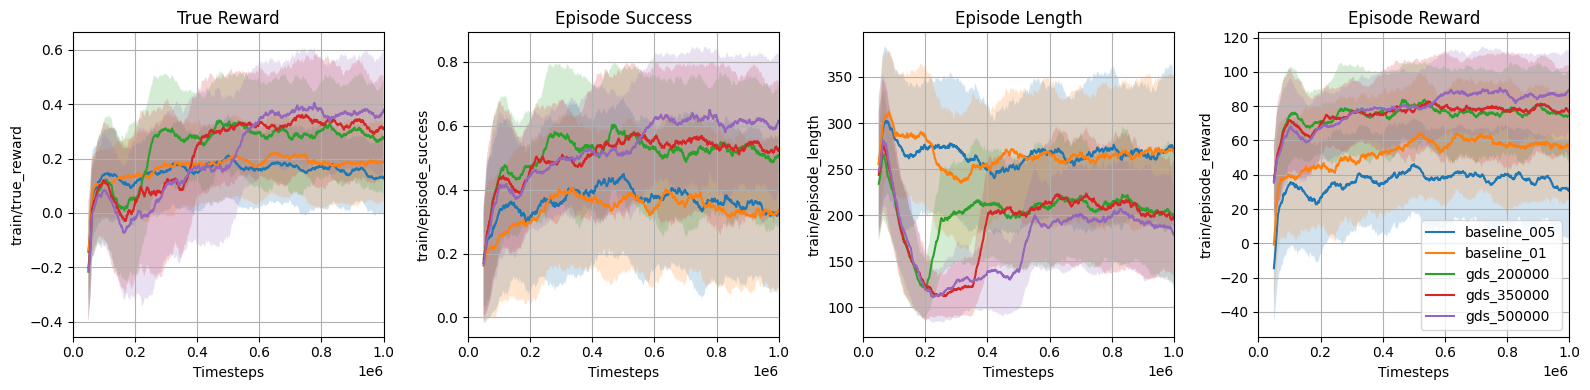

In [109]:
grouped = history.groupby("base_rewards")

# Initialize the plots
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# Plot each metric
metrics = ["train/true_reward", "train/episode_success", "train/episode_length", "train/episode_reward"]
titles = ["True Reward", "Episode Success", "Episode Length", "Episode Reward"]

for i, metric in enumerate(metrics):
    for name, group in grouped:
        mean_values = group.groupby("_step")[metric].mean().rolling(window=50).mean()
        std_values = group.groupby("_step")[metric].std().rolling(window=50).mean()
        timesteps = mean_values.index

        axs[i].plot(timesteps, mean_values, label=f"{name}")
        axs[i].fill_between(timesteps, mean_values - std_values, mean_values + std_values, alpha=0.2)

    axs[i].set_title(titles[i])
    axs[i].set_xlabel("Timesteps")
    axs[i].set_ylabel(metric)
    # axs[i].legend()
    axs[i].grid(True)
    axs[i].set_xlim(0, 1_000_000)

axs[-1].legend()

# axs[0].plot([200_000, 200_000], [-.4, .6], "r--")
# axs[0].plot([350_000, 350_000], [-.4, .6], "r--")
# axs[0].plot([500_000, 500_000], [-.4, .6], "r--")


plt.tight_layout()
# plt.savefig('../figures/curriculum_learning_start.png', dpi=400)
plt.show()

In [102]:
grouped["train/episode_success"].rolling(window=50).mean()

base_rewards     
baseline      0           NaN
              1           NaN
              2           NaN
              3           NaN
              4           NaN
                       ...   
gds_500000    995    0.501056
              996    0.506056
              997    0.514389
              998    0.521056
              999    0.512722
Name: train/episode_success, Length: 15367, dtype: float64

In [110]:
# sweep_id = "odr2t5an"
sweep_id = "p58arwnw"

api = wandb.Api()
sweep = api.sweep(f"kilian/DRL-Traj-Planner/{sweep_id}")

# Fetch the history of all runs in the sweep
history_list = []
for run in sweep.runs:
    run_history = run.history(keys=["train/episode_success", "train/episode_length", "train/true_reward",
                                    "train/episode_collided", "train/loss_qvalue", "train/episode_reward"],
                              pandas=True,
                              samples=1_200_000)
    params = run.config
    run_history["base_rewards"] = "updates_" + str(params["sac"]["curriculum"]["num_updates_after_update"])
    run_history["seed"] = params["seed"]

    history_list.append(run_history)

history = pd.concat(history_list)

In [111]:
history["base_rewards"].value_counts()

base_rewards
updates_100000    3984
updates_25000     3984
updates_1000      3984
updates_50000     3336
Name: count, dtype: int64

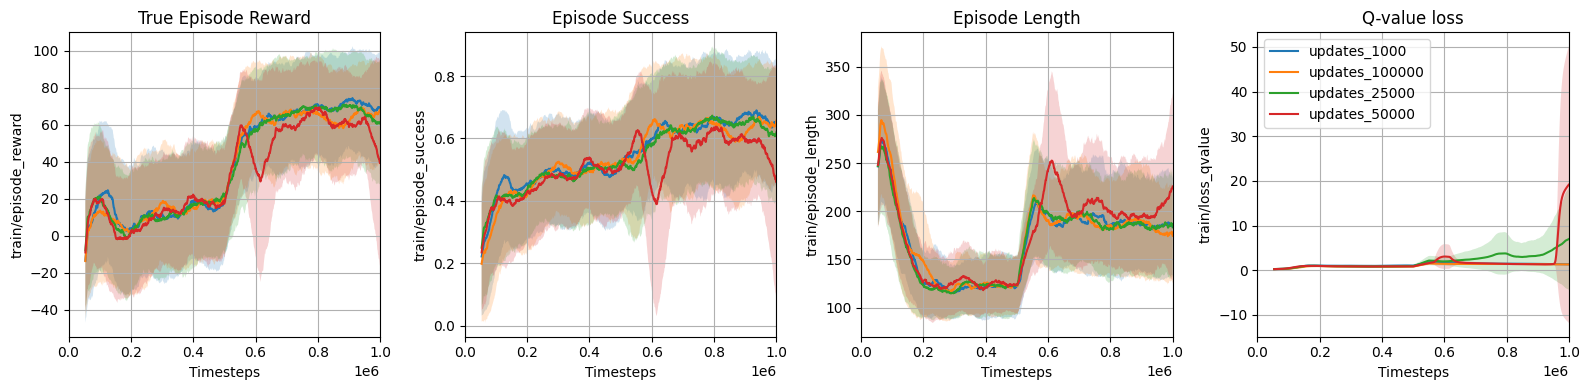

In [114]:
grouped = history.groupby("base_rewards")

# Initialize the plots
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# Plot each metric
metrics = ["train/episode_reward", "train/episode_success", "train/episode_length", "train/loss_qvalue"]#, "train/episode_collided"]
titles = ["True Episode Reward", "Episode Success", "Episode Length", "Q-value loss"]#, "Episode Collided"]

for i, metric in enumerate(metrics):
    for name, group in grouped:
        mean_values = group.groupby("_step")[metric].mean().rolling(window=50).mean()
        std_values = group.groupby("_step")[metric].std().rolling(window=50).mean()
        timesteps = mean_values.index

        axs[i].plot(timesteps, mean_values, label=f"{name}")
        axs[i].fill_between(timesteps, mean_values - std_values, mean_values + std_values, alpha=0.2)

    axs[i].set_title(titles[i])
    axs[i].set_xlabel("Timesteps")
    axs[i].set_ylabel(metric)
    # axs[i].legend()
    axs[i].grid(True)
    axs[i].set_xlim(0, 1_000_000)

axs[-1].legend()

# axs[0].plot([200_000, 200_000], [-.4, .6], "r--")
# axs[0].plot([350_000, 350_000], [-.4, .6], "r--")
# axs[0].plot([500_000, 500_000], [-.4, .6], "r--")

plt.tight_layout()
plt.savefig('../figures/curriculum_learning_iters.png', dpi=400)
plt.show()